In [1]:
import pandas as pd # Pour la manipulation du dataset
import numpy as np  # Pour la calculs mathématique
import matplotlib.pyplot as plt # Pour des graphs
import seaborn as sns   # Pour des graphs
import scipy.stats as stat  # Pour des calculs statistiques
from sklearn.impute import SimpleImputer # Pour la gestion des missings values
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, validation_curve, cross_val_score    # Division le dataset en train et test 
from sklearn.compose import ColumnTransformer   # Transformation des colonnes par types
from sklearn.preprocessing import StandardScaler, OneHotEncoder # Fonction de transformation ou dr preprocessing
from sklearn.decomposition import PCA   # Pour redimensionnalité
from imblearn.pipeline import Pipeline  # Pour réaliser un pipeline
from imblearn.over_sampling import SMOTE    # Pour la technique du sur-échantillonage
from imblearn.under_sampling import RandomUnderSampler  # Pour la technique du sous-échantillonage
from sklearn.exceptions import NotFittedError
## Utilisation du modele 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc, classification_report
import joblib as jb
pd.options.mode.chained_assignment = None


## **Chargement et gestion des valeurs manquantes**

In [ ]:
# Importation des datas
col_name = ["age","rev_annuel","propriete","duree_emploi", 
            "intention","categorie_pret","montant", "interet","statut", "pourcentage_rev",
            "defaut_historique","duree_credit"]
card = pd.read_csv("credit_risk_dataset.csv", delimiter = ",")
# Changement du nom des variables
card.rename(columns=dict(zip(card.columns.to_list(), col_name)), inplace=True)
num = card.select_dtypes(include = [float, int]).columns.to_list()
cat = card.select_dtypes(include = ["object"]).columns.to_list()
num.remove("statut")
print(card.isnull().sum())


age                     0
rev_annuel              0
propriete               0
duree_emploi          895
intention               0
categorie_pret          0
montant                 0
interet              3116
statut                  0
pourcentage_rev         0
defaut_historique       0
duree_credit            0
dtype: int64


In [4]:
# Imputation
impite = SimpleImputer(strategy="mean")
card.loc[:, "interet"] = impite.fit_transform(card[["interet"]])

# Suppression 
card = card.dropna(axis='index')
print("---------------------------------------------------------------------------")
print("Vérification après correction ")
print("---------------------------------------------------------------------------")
print(card.isnull().sum())
card['categorie_pret'].value_counts().reset_index()

---------------------------------------------------------------------------
Vérification après correction 
---------------------------------------------------------------------------
age                  0
rev_annuel           0
propriete            0
duree_emploi         0
intention            0
categorie_pret       0
montant              0
interet              0
statut               0
pourcentage_rev      0
defaut_historique    0
duree_credit         0
dtype: int64


,categorie_pret,count
0,A,10371
1,B,10186
2,C,6321
3,D,3556
4,E,952
5,F,236
6,G,64


## **VALIDATION TEST TRAIN**

In [4]:
# Separation des caractéristique
X = card[["age","rev_annuel","propriete","duree_emploi", 
            "intention","categorie_pret","montant", "interet", "pourcentage_rev",
            "defaut_historique","duree_credit"]]
y = card["statut"]



# Assurez-vous que X et y ont le même nombre de samples
print(f"Nombre de samples dans X: {len(X)}")
print(f"Nombre de samples dans y: {len(y)}")

# Divisez les données en ensembles d'entraînement et de test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.4, random_state=42, stratify=y)
print(f"Nombre de samples dans X_train: {len(X_train)}")
print(f"Nombre de samples dans y_train: {len(y_train)}")


# Vérifiez les dimensions après la première division
print(f"Nombre de samples dans X_temp: {len(X_temp)}")
print(f"Nombre de samples dans y_temp: {len(y_temp)}")

# Divisez les données temporaires en ensembles de validation et de test
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42, stratify=y_temp)

# Vérifiez les dimensions après la deuxième division
print(f"Nombre de samples dans X_test: {len(X_test)}")
print(f"Nombre de samples dans y_test: {len(y_test)}")
print(f"Nombre de samples dans X_val: {len(X_val)}")
print(f"Nombre de samples dans y_val: {len(y_val)}")


Nombre de samples dans X: 31686
Nombre de samples dans y: 31686
Nombre de samples dans X_train: 12674
Nombre de samples dans y_train: 12674
Nombre de samples dans X_temp: 19012
Nombre de samples dans y_temp: 19012
Nombre de samples dans X_test: 9506
Nombre de samples dans y_test: 9506
Nombre de samples dans X_val: 9506
Nombre de samples dans y_val: 9506


## **LOGISTIC MODELE**

In [5]:
## Pipeline du modele d'arbre de décision
# Prétraitement : transformation des colonnes numériques et catégoriques
cat_norm = ["propriete","intention","categorie_pret", "defaut_historique"]
num_norm = ["age","rev_annuel","duree_emploi","montant", "interet", "duree_credit"]
prepros = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_norm),  # Gestion des inconnus
        ("num", StandardScaler(), num_norm)
    ]
)
pipe_log = Pipeline([
    ("preprocessing", prepros),
    ("pca", PCA(n_components=4)),
    ("over", SMOTE(random_state=1)),
    ("under", RandomUnderSampler(random_state=1)),
    ("tree", LogisticRegression(solver='liblinear'))
])
try:
    pipe_log
    print("Modèle chargé avec succès.")
except ValueError as ve:
    print(f"Erreur de valeur : {ve}")
except NotFittedError as nfe:
    print(f"Erreur d'ajustement : {nfe}")
except Exception as e:
    print(f"Erreur générale : {e}")

Modèle chargé avec succès.


In [6]:
# Entrainnement du modele
pipe_log.fit(X_train, y_train)
# Prediction du modele
y_pred0 = pipe_log.predict(X_test)
y_pred0_proba = pipe_log.predict_proba(X_test)[:,1]
y_pred0_proba

array([0.33384568, 0.79613764, 0.41928288, ..., 0.23644804, 0.37888787,
       0.16604237])

In [7]:
pipe_log.predict(X_test)

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [8]:
# Fonction d'évaluation de performance

def model_performance(data_test, data_pred, data_pred_prob):
    cm = (confusion_matrix(data_test, data_pred) / len(data_test)) * 100
    tn, fp, fn, tp = cm.ravel()
    print(classification_report(data_test,data_pred))

    print("True Negatif :", np.round(tn, 3))
    print("False Positif :", np.round(fp,3))
    print("False Negatif : ", np.round(fn,3))
    print("True Positif : ", np.round(tp,3))

    # Taux de positif
    fpr, tpr, _ = roc_curve(data_test, data_pred_prob)
    print("Matrice de Confusion")

    # Afficher la matrice de confusion
    fig, ax = plt.subplots()
    sns.heatmap(np.round(cm, 6), annot=True, cmap='Blues')  # Utilisez une colormap valide
    plt.title('Matrice de Confusion')
    plt.xlabel('Classe Prédite')
    plt.ylabel('Classe Réelle')
    plt.show()
    # Courbe ROC

    # Calculer les métriques ROC 
    roc_auc = roc_auc_score(data_test, data_pred_prob) 
    # Tracer la courbe ROC 
    plt.figure(figsize=(10, 6)) 
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})') 
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--') 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs (FPR)') 
    plt.ylabel('Taux de Vrais Positifs (TPR)') 
    plt.title('Courbe ROC') 
    plt.legend(loc="lower right") 
    plt.show()
    

              precision    recall  f1-score   support

           0       0.89      0.67      0.77      7458
           1       0.37      0.69      0.48      2048

    accuracy                           0.68      9506
   macro avg       0.63      0.68      0.62      9506
weighted avg       0.77      0.68      0.70      9506

True Negatif : 52.924
False Positif : 25.531
False Negatif :  6.743
True Positif :  14.801
Matrice de Confusion


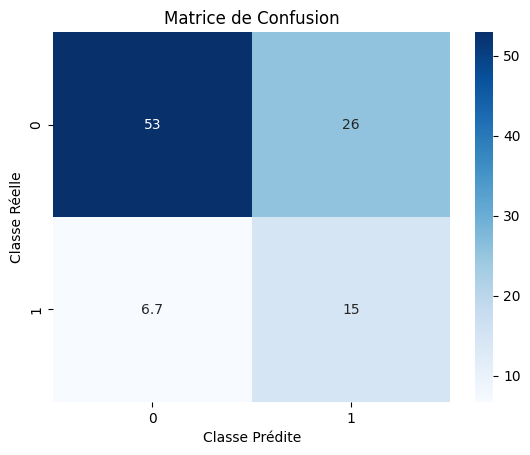

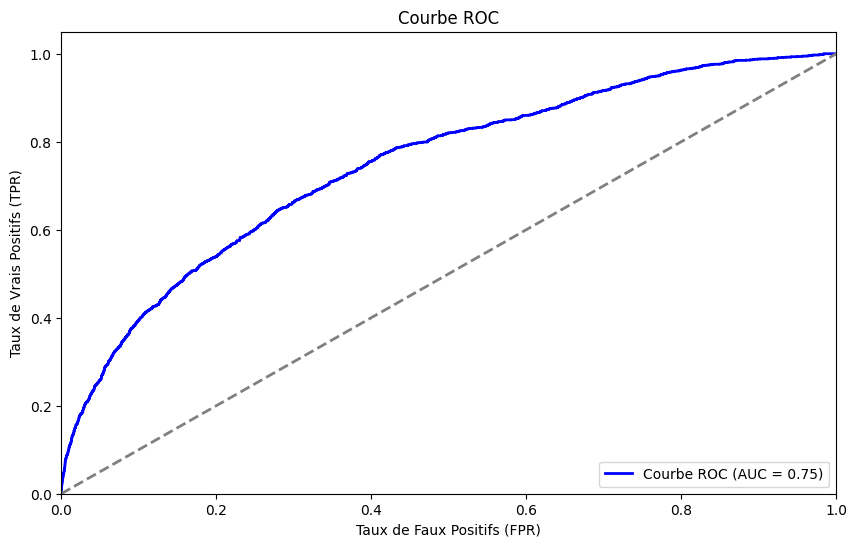

In [9]:
model_performance(y_test, y_pred0, y_pred0_proba)

# **CROSS VALIDATION**
<!-- ##  **VALIDATION CURVE** -->

In [10]:
# Instancier un Kfold
k_fold = KFold(n_splits=5, shuffle=True, random_state=1)
score_cv = cross_val_score(pipe_log, X_train, y_train, cv=k_fold, scoring='roc_auc', n_jobs=-1).mean()
print("AUC avec le Cross validation : ", np.round(score_cv,2))

AUC avec le Cross validation :  0.74


In [11]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Vérifiez les ratios réalisables dynamiquement
def get_valid_ratios(X, y):
    # Distribution des classes
    class_counts = Counter(y)
    major_class = max(class_counts, key=class_counts.get)
    minor_class = min(class_counts, key=class_counts.get)
    
    n_major = class_counts[major_class]
    n_minor = class_counts[minor_class]
    
    # Calcul des ratios réalisables
    max_over_ratio = n_major / n_minor - 1
    max_under_ratio = n_minor / n_major
    
    # Retourne des listes de valeurs réalisables
    over_ratios = [r for r in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] if r <= max_over_ratio]
    under_ratios = [r for r in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] if r <= max_under_ratio]
    
    return over_ratios, under_ratios

# Exemple d'utilisation avec vos données d'entraînement
over_ratios, under_ratios = get_valid_ratios(X_train, y_train)
print(over_ratios,under_ratios)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] [0.1, 0.2]


<!-- from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Vérifiez les ratios réalisables dynamiquement
def get_valid_ratios(X, y):
    # Distribution des classes
    class_counts = Counter(y)
    major_class = max(class_counts, key=class_counts.get)
    minor_class = min(class_counts, key=class_counts.get)
    
    n_major = class_counts[major_class]
    n_minor = class_counts[minor_class]
    
    # Calcul des ratios réalisables
    max_over_ratio = n_major / n_minor - 1
    max_under_ratio = n_minor / n_major
    
    # Retourne des listes de valeurs réalisables
    over_ratios = [r for r in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] if r <= max_over_ratio]
    under_ratios = [r for r in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] if r <= max_under_ratio]
    
    return over_ratios, under_ratios

# Exemple d'utilisation avec vos données d'entraînement
over_ratios, under_ratios = get_valid_ratios(X_train, y_train) -->


In [12]:
# Separation des caractéristique
X = card[["age","rev_annuel","propriete","duree_emploi", 
            "intention","categorie_pret","montant", "interet", "pourcentage_rev",
            "defaut_historique","duree_credit"]]
y = card["statut"]

# Assurez-vous que X et y ont le même nombre de samples

# Divisez les données en ensembles d'entraînement et de test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.4, random_state=42, stratify=y)

# Divisez les données temporaires en ensembles de validation et de test
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42, stratify=y_temp)

# Instancier un Kfold
k_fold = KFold(n_splits=5, shuffle=True, random_state=1)

# Définir les colonnes catégoriques et numériques
cat_norm = ["propriete", "intention", "categorie_pret", "defaut_historique"]
num_norm = ["age", "rev_annuel", "duree_emploi", "montant", "interet", "duree_credit"]

# Création du transformateur pour les colonnes
prepros = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_norm),  # Gestion des inconnus
        ("num", StandardScaler(), num_norm)
    ]
)

# Construction du pipeline
pipe_log = Pipeline([
    ("preprocessing", prepros),
    ("pca", PCA(n_components=5)),
    ("under", RandomUnderSampler(random_state=1)),
    ("tree", LogisticRegression(solver='liblinear'))
])

# Définition de la grille des hyperparamètres
param_grid = {
    'under__sampling_strategy': [0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9,1],  # Proportions réalistes pour RandomUnderSampler
    'tree__solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'] # Exclusion de solveurs incompatibles
    }

# Définir GridSearchCV
log_grid = GridSearchCV(
    pipe_log, param_grid, scoring='roc_auc', cv=k_fold, n_jobs=-1, error_score='raise'
)

# Ajuster le modèle en capturant les erreurs
try:
    log_grid.fit(X_train, y_train)
    print("Modèle ajusté avec succès.")
except ValueError as ve:
    print(f"Erreur de valeur : {ve}")
except NotFittedError as nfe:
    print(f"Erreur d'ajustement : {nfe}")
except Exception as e:
    print(f"Erreur générale : {e}")


Modèle ajusté avec succès.


In [13]:
print(log_grid.best_params_)
print(log_grid.best_estimator_)

{'tree__solver': 'lbfgs', 'under__sampling_strategy': 0.3}
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['propriete', 'intention',
                                                   'categorie_pret',
                                                   'defaut_historique']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'rev_annuel',
                                                   'duree_emploi', 'montant',
                                                   'interet',
                                                   'duree_credit'])])),
                ('pca', PCA(n_components=5)),
                ('under',
                 RandomUnderSampler(random_state=1, sampling_strategy=0.3)),
                ('tree', Logisti

## Evaluation finale du modele

In [14]:
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['propriete', 'intention',
                                                   'categorie_pret',
                                                   'defaut_historique']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'rev_annuel',
                                                   'duree_emploi', 'montant',
                                                   'interet',
                                                   'duree_credit'])])),
                ('pca', PCA(n_components=5)),
                ('under',
                 RandomUnderSampler(random_state=1, sampling_strategy=0.3)),
                ('tree', LogisticRegression())])

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['propriete', 'intention',
                                                   'categorie_pret',
                                                   'defaut_historique']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'rev_annuel',
                                                   'duree_emploi', 'montant',
                                                   'interet',
                                                   'duree_credit'])])),
                ('pca', PCA(n_components=5)),
                ('under',
                 RandomUnderSampler(random_state=1, sampling_strategy=0.3)),
                ('tree', LogisticRegression())])

In [15]:
# Entrainnement
pipe_log.fit(X_train,y_train)

# Prediction
pred_val = pipe_log.predict(X_val)
pred_prob = pipe_log.predict_proba(X_val)[:,1]


              precision    recall  f1-score   support

           0       0.91      0.70      0.79      7458
           1       0.41      0.75      0.53      2048

    accuracy                           0.71      9506
   macro avg       0.66      0.73      0.66      9506
weighted avg       0.80      0.71      0.74      9506

True Negatif : 55.007
False Positif : 23.448
False Negatif :  5.365
True Positif :  16.179
Matrice de Confusion


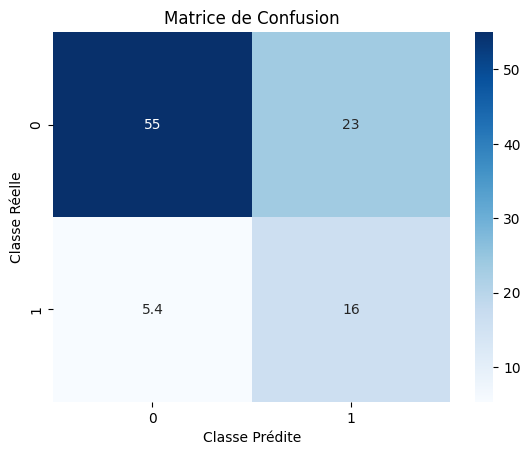

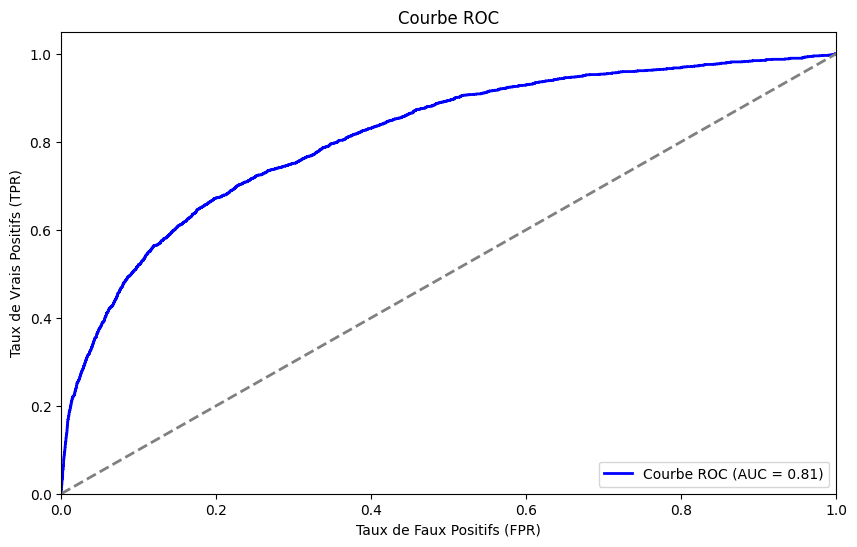

In [16]:
model_performance(y_val, pred_val, pred_prob)

In [17]:
# Packager le modele
jb.dump(pipe_log, "logistic.pkl")


['logistic.pkl']

## **DECISION TREE MODELE**

In [18]:
## Pipeline du modele d'arbre de décision
# Prétraitement : transformation des colonnes numériques et catégoriques
cat_prepos = ["propriete","intention","categorie_pret", "defaut_historique"]
num_prepos = ["age","rev_annuel","duree_emploi","montant", "interet", "duree_credit"]
prepros = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_prepos)] # Gestion des inconnus    ]
)
pipe_tree = Pipeline([
    ("preprocessing", prepros),
    ("under", RandomUnderSampler(random_state=1)),
    ("tree", DecisionTreeClassifier(criterion="gini",splitter="best",max_depth=2))
])


In [19]:
# Entrainement du modèle
pipe_tree.fit(X_train, y_train)

# Prediction
y_pred_val = pipe_tree.predict(X_test)
y_pred_prob = pipe_tree.predict_proba(X_test)[:,1]

              precision    recall  f1-score   support

           0       0.91      0.52      0.66      7458
           1       0.32      0.81      0.46      2048

    accuracy                           0.58      9506
   macro avg       0.61      0.66      0.56      9506
weighted avg       0.78      0.58      0.62      9506

True Negatif : 40.9
False Positif : 37.555
False Negatif :  4.124
True Positif :  17.421
Matrice de Confusion


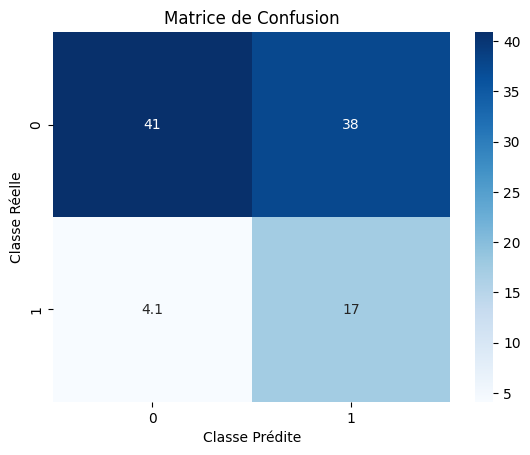

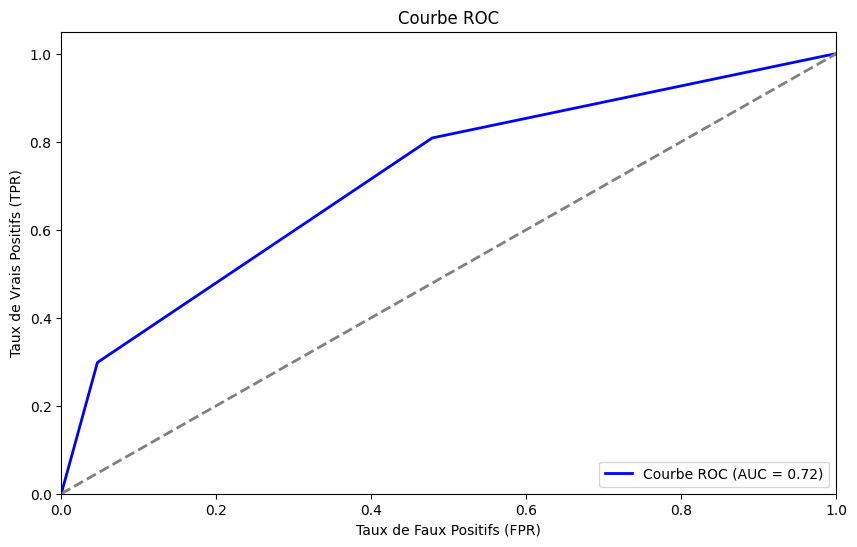

In [20]:
# Metrics de performance
model_performance(y_test,y_pred_val,y_pred_prob)

## Cross Validation

In [21]:
## Pipeline du modele d'arbre de décision
# Prétraitement : transformation des colonnes numériques et catégoriques
cat_prepos = ["propriete","intention","categorie_pret", "defaut_historique"]
num_prepos = ["age","rev_annuel","duree_emploi","montant", "interet", "duree_credit"]
prepros = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_prepos),
        ('scaler', StandardScaler(),num_prepos)] # Gestion des inconnus    ]
)
pipe_tree = Pipeline([
    ("preprocessing", prepros),
    ("under", RandomUnderSampler(random_state=1)),
    ("tree", DecisionTreeClassifier(splitter="best",max_depth=2))
])



kfold = KFold(n_splits=5, shuffle=True, random_state=1)
tree_score = cross_val_score(pipe_tree, X_train, y_train, cv=kfold,scoring="roc_auc").mean()
print(np.round(tree_score, 2))


0.76


## Amelioration du modele

In [22]:

# Définir les paramètres pour GridSearchCV
para_grid = {
    'under__sampling_strategy': [0.5, 0.6, 0.7, 0.8, 0.9],
    'tree__criterion': ['gini', 'entropy', 'log_loss'],
    'tree__max_depth': [2, 3, 5, 6, 7]
}

# Initialiser GridSearchCV
tree_grid = GridSearchCV(pipe_tree, para_grid, scoring='roc_auc', n_jobs=-1, cv=kfold)

# Gestion des erreurs lors de l'ajustement du modèle
try:
    tree_grid.fit(X_train, y_train)
    print("Modèle est bien ajusté")
except Exception as e:
    print(f"Erreur lors de l'ajustement du modèle : {e}")


Modèle est bien ajusté


In [23]:
print(tree_grid.best_params_)
print(tree_grid.best_estimator_)

{'tree__criterion': 'log_loss', 'tree__max_depth': 7, 'under__sampling_strategy': 0.5}
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['propriete', 'intention',
                                                   'categorie_pret',
                                                   'defaut_historique']),
                                                 ('scaler', StandardScaler(),
                                                  ['age', 'rev_annuel',
                                                   'duree_emploi', 'montant',
                                                   'interet',
                                                   'duree_credit'])])),
                ('under',
                 RandomUnderSampler(random_state=1, sampling_strategy=0.5)),
                ('tree',
                 Decis

In [24]:
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['propriete', 'intention',
                                                   'categorie_pret',
                                                   'defaut_historique']),
                                                 ('scaler', StandardScaler(),
                                                  ['age', 'rev_annuel',
                                                   'duree_emploi', 'montant',
                                                   'interet',
                                                   'duree_credit'])])),
                ('under',
                 RandomUnderSampler(random_state=1, sampling_strategy=0.5)),
                ('tree',
                 DecisionTreeClassifier(criterion='log_loss', max_depth=7))])

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['propriete', 'intention',
                                                   'categorie_pret',
                                                   'defaut_historique']),
                                                 ('scaler', StandardScaler(),
                                                  ['age', 'rev_annuel',
                                                   'duree_emploi', 'montant',
                                                   'interet',
                                                   'duree_credit'])])),
                ('under',
                 RandomUnderSampler(random_state=1, sampling_strategy=0.5)),
                ('tree',
                 DecisionTreeClassifier(criterion='log_loss', max_depth=7))])

In [25]:
# Entrainnement
pipe_tree.fit(X_train,y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['propriete', 'intention',
                                                   'categorie_pret',
                                                   'defaut_historique']),
                                                 ('scaler', StandardScaler(),
                                                  ['age', 'rev_annuel',
                                                   'duree_emploi', 'montant',
                                                   'interet',
                                                   'duree_credit'])])),
                ('under', RandomUnderSampler(random_state=1)),
                ('tree', DecisionTreeClassifier(max_depth=2))])

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      7458
           1       0.44      0.68      0.53      2048

    accuracy                           0.74      9506
   macro avg       0.67      0.72      0.68      9506
weighted avg       0.80      0.74      0.76      9506

True Negatif : 59.51
False Positif : 18.946
False Negatif :  6.922
True Positif :  14.622
Matrice de Confusion


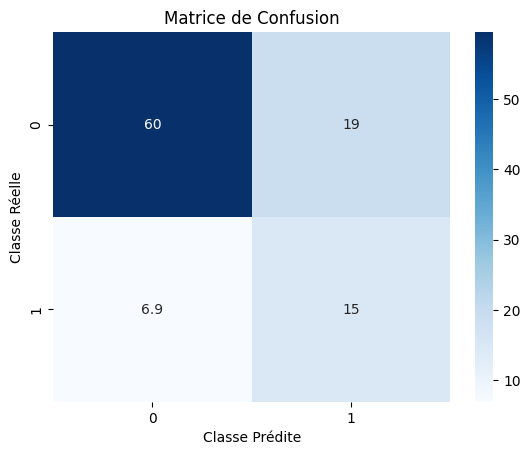

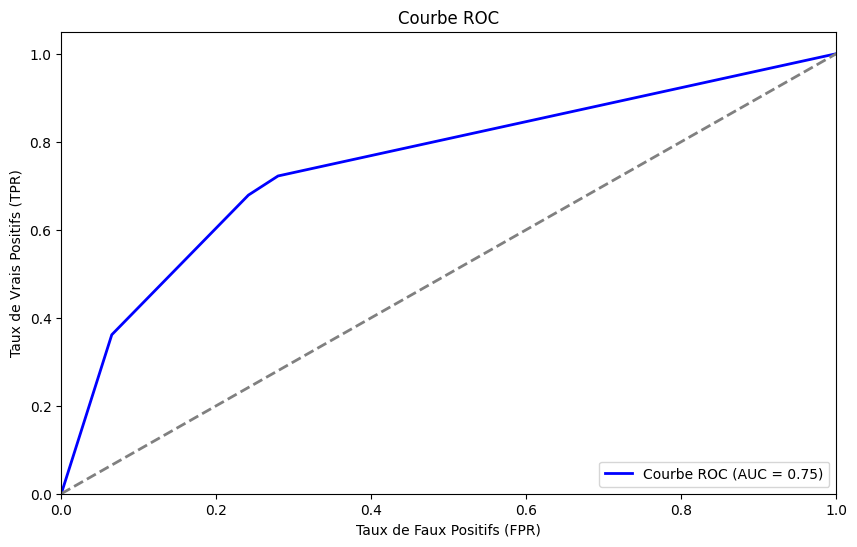

In [26]:
predval = pipe_tree.predict(X_val)
preprob = pipe_tree.predict_proba(X_val)[:,1]

model_performance(y_val, predval,preprob)

In [27]:
# packager le modele
jb.dump(pipe_tree, 'decision_tree.pkl')

['decision_tree.pkl']